In [ ]:
##################################### SETUP ####################################
import os
import glob
import json
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import PIL
from pathlib import Path
import time
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import image_dataset_from_directory
from keras import layers
from IPython.display import Image, display



DATASET_FILENAME     = "deep_pen_dataset"
SAVED_MODEL_FILENAME = "saved_model"
FMODEL_FILENAME      = "float_model.tfl"
QMODEL_FILENAME      = "quantized_model.tfl"
MODEL_FILENAME       = "deep_pen_model_data.cc"

!apt-get -qq update && apt-get -qq install xxd

!wget "https://drive.google.com/uc?export=download&id=1NBUAHjxW3ROO3EUmQORnxDMvTSJbj-R6" -O {DATASET_FILENAME}.tar.gz -q
!rm -rf {DATASET_FILENAME}
!tar xvzf {DATASET_FILENAME}.tar.gz 1>/dev/null
!rm -rf {DATASET_FILENAME}.tar.gz sample_data
!mkdir -p checkpoints

print("OK") if os.path.exists(DATASET_FILENAME) else print("Error")

Selecting previously unselected package xxd.
(Reading database ... 155632 files and directories currently installed.)
Preparing to unpack .../xxd_2%3a8.0.1453-1ubuntu1.8_amd64.deb ...
Unpacking xxd (2:8.0.1453-1ubuntu1.8) ...
Setting up xxd (2:8.0.1453-1ubuntu1.8) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
OK


In [ ]:
##TEMPORARY
siu = ["0", "1", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "2", "20", "21", "22", "23", "24", "25", "3", "4", "5", "6", "7", "8", "9"]

In [ ]:
############################### READ THE STROKES ###############################
strokes = []
for filename in glob.glob("deep_pen_dataset/*.json"):
  with open(filename, "r") as file:
    file_data = file.read()
  json_data = json.loads(file_data)
  for stroke in json_data["strokes"]:
    stroke["filename"] = filename
    strokes.append(stroke)

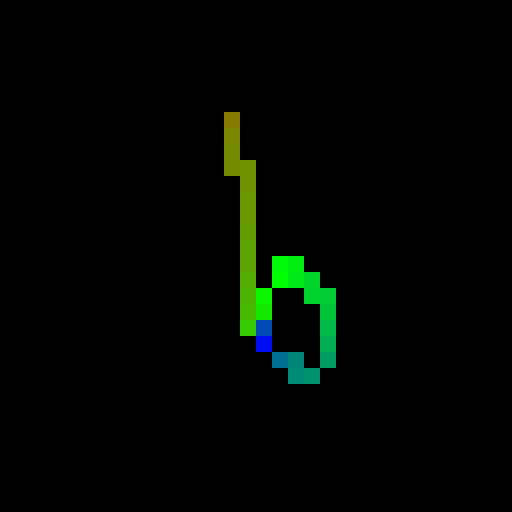

In [ ]:
FIXED_POINT = 256

def mul_fp(a, b):
  return (a * b) / FIXED_POINT

def div_fp(a, b):
  if b == 0:
    b = 1
  return (a * FIXED_POINT) / b

def float_to_fp(a):
  return math.floor(a * FIXED_POINT)

def norm_to_coord_fp(a, range_fp, half_size_fp):
  a_fp = float_to_fp(a)
  norm_fp = div_fp(a_fp, range_fp)
  return mul_fp(norm_fp, half_size_fp) + half_size_fp

def round_fp_to_int(a):
  return math.floor((a + (FIXED_POINT / 2)) / FIXED_POINT)

def gate(a, min, max):
  if a < min:
    return min
  elif a > max:
    return max
  else:
    return a

def rasterize_stroke(stroke_points, x_range, y_range, width, height):
  num_channels = 3
  buffer_byte_count = height * width * num_channels
  buffer = bytearray(buffer_byte_count)

  width_fp = width * FIXED_POINT
  height_fp = height * FIXED_POINT
  half_width_fp = width_fp / 2
  half_height_fp = height_fp / 2
  x_range_fp = float_to_fp(x_range)
  y_range_fp = float_to_fp(y_range)

  t_inc_fp = FIXED_POINT / len(stroke_points)

  one_half_fp = (FIXED_POINT / 2)

  for point_index in range(len(stroke_points) - 1):
    start_point = stroke_points[point_index]
    end_point = stroke_points[point_index + 1]
    start_x_fp = norm_to_coord_fp(start_point["x"], x_range_fp, half_width_fp)
    start_y_fp = norm_to_coord_fp(-start_point["y"], y_range_fp, half_height_fp)
    end_x_fp = norm_to_coord_fp(end_point["x"], x_range_fp, half_width_fp)
    end_y_fp = norm_to_coord_fp(-end_point["y"], y_range_fp, half_height_fp)
    delta_x_fp = end_x_fp - start_x_fp
    delta_y_fp = end_y_fp - start_y_fp

    t_fp = point_index * t_inc_fp
    if t_fp < one_half_fp:
      local_t_fp = div_fp(t_fp, one_half_fp)
      one_minus_t_fp = FIXED_POINT - local_t_fp
      red = round_fp_to_int(one_minus_t_fp * 255)
      green = round_fp_to_int(local_t_fp * 255)
      blue = 0
    else:
      local_t_fp = div_fp(t_fp - one_half_fp, one_half_fp)
      one_minus_t_fp = FIXED_POINT - local_t_fp
      red = 0
      green = round_fp_to_int(one_minus_t_fp * 255)
      blue = round_fp_to_int(local_t_fp * 255)
    red = gate(red, 0, 255)
    green = gate(green, 0, 255)
    blue = gate(blue, 0, 255)

    if abs(delta_x_fp) > abs(delta_y_fp):
      line_length = abs(round_fp_to_int(delta_x_fp))
      if delta_x_fp > 0:
        x_inc_fp = 1 * FIXED_POINT
        y_inc_fp = div_fp(delta_y_fp, delta_x_fp)
      else:
        x_inc_fp = -1 * FIXED_POINT
        y_inc_fp = -div_fp(delta_y_fp, delta_x_fp)
    else:
      line_length = abs(round_fp_to_int(delta_y_fp))
      if delta_y_fp > 0:
        y_inc_fp = 1 * FIXED_POINT
        x_inc_fp = div_fp(delta_x_fp, delta_y_fp)
      else:
        y_inc_fp = -1 * FIXED_POINT
        x_inc_fp = -div_fp(delta_x_fp, delta_y_fp)
    for i in range(line_length + 1):
      x_fp = start_x_fp + (i * x_inc_fp)
      y_fp = start_y_fp + (i * y_inc_fp)
      x = round_fp_to_int(x_fp)
      y = round_fp_to_int(y_fp)
      if (x < 0) or (x >= width) or (y < 0) or (y >= height):
        continue
      buffer_index = (y * width * num_channels) + (x * num_channels)
      buffer[buffer_index + 0] = red
      buffer[buffer_index + 1] = green
      buffer[buffer_index + 2] = blue
  
  np_buffer = np.frombuffer(buffer, dtype=np.uint8).reshape(height, width, num_channels)

  return np_buffer


raster = rasterize_stroke(strokes[11]["strokePoints"], 0.5, 0.5, 32, 32)
PIL.Image.fromarray(raster).resize((512, 512), PIL.Image.NEAREST)


In [ ]:
########################## RASTERIZE STROKES AS IMAGES #########################

X_RANGE = 0.6
Y_RANGE = 0.6

def ensure_empty_dir(dirname):
  dirpath = Path(dirname)
  if dirpath.exists() and dirpath.is_dir():
    shutil.rmtree(dirpath)
  dirpath.mkdir()

def augment_points(points, move_range, scale_range, rotate_range):
  move_x = np.random.uniform(low=-move_range, high=move_range)
  move_y = np.random.uniform(low=-move_range, high=move_range)
  scale = np.random.uniform(low=1.0-scale_range, high=1.0+scale_range)
  rotate = np.random.uniform(low=-rotate_range, high=rotate_range)

  x_axis_x = math.cos(rotate) * scale
  x_axis_y = math.sin(rotate) * scale

  y_axis_x = -math.sin(rotate) * scale
  y_axis_y = math.cos(rotate) * scale

  new_points = []
  for point in points:
    old_x = point["x"]
    old_y = point["y"]
    new_x = (x_axis_x * old_x) + (x_axis_y * old_y) + move_x
    new_y = (y_axis_x * old_x) + (y_axis_y * old_y) + move_y
    new_points.append({"x": new_x, "y": new_y})

  return new_points

def save_strokes_as_images(strokes, root_folder, width, height, augment_count):
  ensure_empty_dir(root_folder)
  labels = set()
  for stroke in strokes:
    labels.add(stroke["label"].lower())
  for label in labels:
    label_path = Path(root_folder, label)
    ensure_empty_dir(label_path)

  label_counts = {}
  for stroke in strokes:
    points = stroke["strokePoints"]
    label = stroke["label"].lower()
    if label == "":
      raise Exception("Missing label for %s:%d" % (stroke["filename"], stroke["index"]))
    if label not in label_counts:
      label_counts[label] = 0
    label_count = label_counts[label]
    label_counts[label] += 1
    raster = rasterize_stroke(points, X_RANGE, Y_RANGE, width, height)
    image = PIL.Image.fromarray(raster)
    image.save(Path(root_folder, label, str(label_count) + ".png"))
    for i in range(augment_count):
      augmented_points = augment_points(points, 0.1, 0.1, 0.3)
      raster = rasterize_stroke(augmented_points, X_RANGE, Y_RANGE, width, height)
      image = PIL.Image.fromarray(raster)
      image.save(Path(root_folder, label, str(label_count) + "_a" + str(i) + ".png"))

  return labels


In [ ]:
############################# DIVIDE IMAGES BY USE ############################# 

IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32

shuffled_strokes = strokes
np.random.shuffle(shuffled_strokes)

test_percentage = 10
validation_percentage = 10
train_percentage = 100 - (test_percentage + validation_percentage)

test_count = math.floor((len(shuffled_strokes) * test_percentage) / 100)
validation_count = math.floor((len(shuffled_strokes) * validation_percentage) / 100)
test_strokes = shuffled_strokes[0:test_count]
validation_strokes = shuffled_strokes[test_count:(test_count + validation_count)]
train_strokes = shuffled_strokes[(test_count + validation_count):]

labels_test  = save_strokes_as_images(test_strokes, "test", IMAGE_WIDTH, IMAGE_HEIGHT, 10)
labels_val   = save_strokes_as_images(validation_strokes, "validation", IMAGE_WIDTH, IMAGE_HEIGHT, 0)
labels_train = save_strokes_as_images(train_strokes, "train", IMAGE_WIDTH, IMAGE_HEIGHT, 10)

In [ ]:
############################### PREPARE DATASETS ###############################
validation_ds = image_dataset_from_directory(
    directory='validation',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT)
).prefetch(buffer_size=32)

train_ds = image_dataset_from_directory(
    directory='train',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT)
).prefetch(buffer_size=32)

Found 430 files belonging to 26 classes.
Found 37840 files belonging to 26 classes.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 16)        1216      
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 16)       64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 14, 14, 16)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 32)          12832     
                                                        

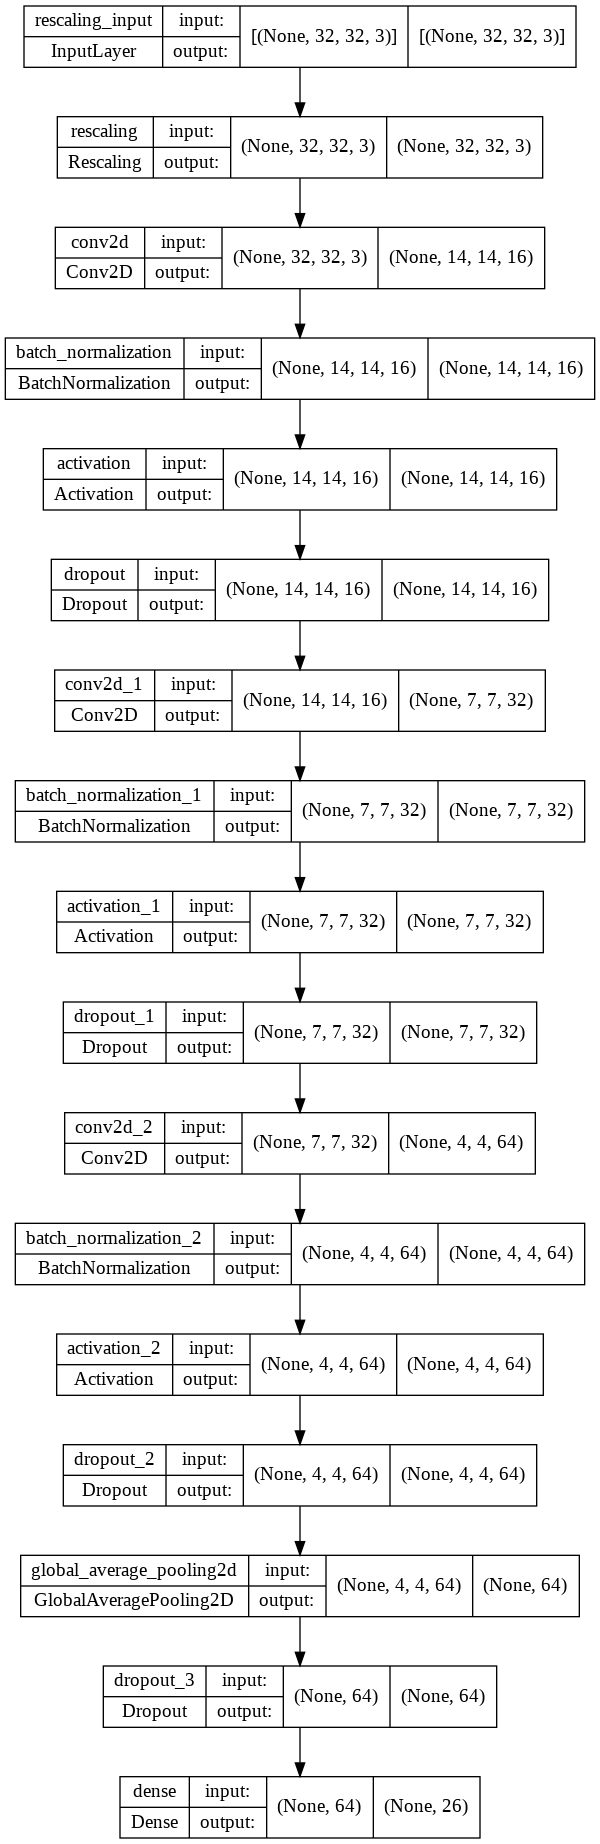

In [ ]:
############################### MAKING THE MODEL ###############################

def make_model(input_shape, num_classes):
  model = models.Sequential()
  model.add( layers.Rescaling(1.0 / 255) )
  model.add( layers.Conv2D(16, 5, strides=2, input_shape=input_shape) )
  model.add( layers.BatchNormalization() )
  model.add( layers.Activation("relu") )
  model.add( layers.Dropout(0.5) )

  model.add( layers.Conv2D(32, 5, strides=2, padding="same") )
  model.add( layers.BatchNormalization() )
  model.add( layers.Activation("relu") )
  model.add( layers.Dropout(0.5) )

  model.add( layers.Conv2D(64, 5, strides=2, padding="same") )
  model.add( layers.BatchNormalization() )
  model.add( layers.Activation("relu") )
  model.add( layers.Dropout(0.5) )

  model.add( layers.GlobalAveragePooling2D() )
  model.add( layers.Dropout(0.5) )

  model.add( layers.Dense(num_classes, activation="softmax") )

  return model

model = make_model(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), num_classes=26)
model.build(input_shape=(None, IMAGE_WIDTH, IMAGE_HEIGHT, 3))
model.summary()
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
############################## TRAINING THE MODEL ##############################
epochs        = 80
learning_rate = 0,001

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, validation_data=validation_ds,
)

Epoch 1/20
1183/1183 [==============================] - 26s 11ms/step - loss: 0.1776 - accuracy: 0.1647 - val_loss: 0.0933 - val_accuracy: 0.5884
Epoch 2/20
1183/1183 [==============================] - 13s 11ms/step - loss: 0.1036 - accuracy: 0.4659 - val_loss: 0.0502 - val_accuracy: 0.8953
Epoch 3/20
1183/1183 [==============================] - 13s 11ms/step - loss: 0.0784 - accuracy: 0.6303 - val_loss: 0.0330 - val_accuracy: 0.9698
Epoch 4/20
1183/1183 [==============================] - 13s 11ms/step - loss: 0.0666 - accuracy: 0.7067 - val_loss: 0.0239 - val_accuracy: 0.9721
Epoch 5/20
1183/1183 [==============================] - 12s 10ms/step - loss: 0.0598 - accuracy: 0.7472 - val_loss: 0.0190 - val_accuracy: 0.9814
Epoch 6/20
1183/1183 [==============================] - 13s 11ms/step - loss: 0.0551 - accuracy: 0.7741 - val_loss: 0.0157 - val_accuracy: 0.9837
Epoch 7/20
1183/1183 [==============================] - 13s 11ms/step - loss: 0.0519 - accuracy: 0.7948 - val_loss: 0.0141 -

In [ ]:
################################## TEST THE MODEL ###############################
def predict_image(model, filename):
  img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis
  predictions = model.predict(img_array).flatten()
  predicted_label_index = np.argmax(predictions)
  predicted_score = predictions[predicted_label_index]
  return (predicted_label_index, predicted_score)
  
index, score = predict_image(model, "test/1/2.png")

print(index, score)

1 0.97861505


In [ ]:
################################ SAVE THE MODEL ################################
model.save(SAVED_MODEL_FILENAME)

INFO:tensorflow:Assets written to: saved_model/assets


In [ ]:
############################## MAKING QUANT MODEL ##############################
### Pete Warden Script
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_FILENAME)
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(FMODEL_FILENAME, "wb").write(model_no_quant_tflite)

def representative_dataset():
  for filename in glob.glob("test/*/*.png"):
    img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis for images, labels in train_ds.take(1):
    yield([img_array])

# Set Optimize flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(QMODEL_FILENAME, "wb").write(model_tflite)

73904

In [ ]:
############################## TEST THE TFLITE MODEL ###########################
def predict_tflite(tflite_model, filename):
  img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # If required, quantize the input layer (from float to integer)
  input_scale, input_zero_point = input_details["quantization"]
  if (input_scale, input_zero_point) != (0.0, 0):
    img_array = np.multiply(img_array, 1.0 / input_scale) + input_zero_point
    img_array = img_array.astype(input_details["dtype"])
  
  # Invoke the interpreter
  interpreter.set_tensor(input_details["index"], img_array)
  interpreter.invoke()
  pred = interpreter.get_tensor(output_details["index"])[0]
  
  # If required, dequantized the output layer (from integer to float)
  output_scale, output_zero_point = output_details["quantization"]
  if (output_scale, output_zero_point) != (0.0, 0):
    pred = pred.astype(np.float32)
    pred = np.multiply((pred - output_zero_point), output_scale)
  
  predicted_label_index = np.argmax(pred)
  predicted_score = pred[predicted_label_index]
  return ( siu[predicted_label_index], predicted_score)

image_to_test = ""
for i in range(0,26):
  image_to_test = "test/" + str(i) + "/0.png"
  print(i,":")
  print(predict_tflite(model_no_quant_tflite, image_to_test) )
  print(predict_tflite(model_tflite,          image_to_test), "\n")

0 :
('0', 0.9997402)
('0', 0.99609375) 

1 :
('1', 0.9999405)
('1', 0.99609375) 

2 :
('2', 0.99993205)
('2', 0.99609375) 

3 :
('3', 0.99938333)
('3', 0.99609375) 

4 :
('4', 0.99679714)
('4', 0.99609375) 

5 :
('5', 0.98976654)
('5', 0.98828125) 

6 :
('6', 0.98887897)
('6', 0.984375) 

7 :
('7', 0.9778593)
('7', 0.9765625) 

8 :
('8', 0.9659312)
('8', 0.95703125) 

9 :
('9', 0.9846793)
('9', 0.98046875) 

10 :
('10', 0.8585332)
('10', 0.85546875) 

11 :
('11', 0.8980961)
('11', 0.88671875) 

12 :
('12', 0.998896)
('12', 0.99609375) 

13 :
('13', 0.998097)
('13', 0.99609375) 

14 :
('14', 0.999803)
('14', 0.99609375) 

15 :
('15', 0.9989594)
('15', 0.99609375) 

16 :
('16', 0.9999659)
('16', 0.99609375) 

17 :
('17', 0.99986625)
('17', 0.99609375) 

18 :
('18', 0.9767853)
('18', 0.9765625) 

19 :
('19', 0.9837981)
('19', 0.984375) 

20 :
('20', 0.9963322)
('20', 0.99609375) 

21 :
('21', 0.9997435)
('21', 0.99609375) 

22 :
('22', 0.9999975)
('22', 0.99609375) 

23 :
('23', 0.9999674

In [ ]:
################################## COMPARE MODELS ##############################
### Pete Warden Script
def get_dir_size(dir):
  size = 0
  for f in os.scandir(dir):
    if f.is_file():
      size += f.stat().st_size
    elif f.is_dir():
      size += get_dir_size(f.path)
  return size

# Calculate size
size_tf = get_dir_size(SAVED_MODEL_FILENAME)
size_no_quant_tflite = os.path.getsize(FMODEL_FILENAME)
size_tflite = os.path.getsize(QMODEL_FILENAME)

# Compare size
pd.DataFrame.from_records(
    [["TensorFlow", f"{size_tf} bytes", ""],
     ["TensorFlow Lite", f"{size_no_quant_tflite} bytes ", f"(reduced by {size_tf - size_no_quant_tflite} bytes)"],
     ["TensorFlow Lite Quantized", f"{size_tflite} bytes", f"(reduced by {size_no_quant_tflite - size_tflite} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")


,Size,
Model,,
TensorFlow,1149225 bytes,
TensorFlow Lite,271372 bytes,(reduced by 877853 bytes)
TensorFlow Lite Quantized,73904 bytes,(reduced by 197468 bytes)


In [ ]:
############################# PRINT labels[] FOR SKETCH ########################
labels = sorted( labels_train.union(labels_val, labels_test) )
num_labels = len(labels)

ordered_labels = "{"
for i in range(0, num_labels):
  ordered_labels += "\"" + str(labels[i]) + ("\", " if i!=num_labels-1 else "\"")
ordered_labels += "}"

print("#labels :", num_labels, "\nlabels[]:", ordered_labels)

#labels : 26 
labels[]: {"0", "1", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "2", "20", "21", "22", "23", "24", "25", "3", "4", "5", "6", "7", "8", "9"}


In [ ]:
6 ################################## MODEL TO BINARY #############################
# Model to c/c++ format and Set model names
!xxd -i {QMODEL_FILENAME} > {MODEL_FILENAME}
REPLACE_TEXT = QMODEL_FILENAME.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/deep_pen_model_data/g' {MODEL_FILENAME}

# My c++ header
!echo "/* =================== deep_pen_model_data.cpp ==================="
!echo "    Sketch for DeepPen\n    By Antonio Priego Raya"
!echo "    Code created for the DeepPen project:"
!echo "    https://github.com/AntonioPriego/DeepPen"
!echo "    Code supported on the magic_wand of Pete Warden"
!echo "    (https://github.com/petewarden/magic_wand)"
!echo "================================================================== */"
!echo ""
!cat {MODEL_FILENAME}

Se han truncado las últimas 5000 líneas del flujo de salida.
  0xec, 0x36, 0xc8, 0x35, 0xea, 0x23, 0xdf, 0xf3, 0x01, 0xdf, 0x07, 0x15,
  0x10, 0xf6, 0xb1, 0xe2, 0xe2, 0xf4, 0xd2, 0xf0, 0x03, 0xd7, 0xb0, 0x1c,
  0xbf, 0xe9, 0xce, 0xee, 0xdc, 0xeb, 0xeb, 0x2d, 0xf0, 0x38, 0xf6, 0x52,
  0xe0, 0x1c, 0xdf, 0xf9, 0x0d, 0xee, 0xf9, 0x11, 0x07, 0x02, 0x9e, 0xde,
  0xea, 0x0b, 0xe0, 0xd9, 0x03, 0xd8, 0xe6, 0x12, 0xe4, 0x16, 0xc5, 0xdf,
  0xb9, 0xf0, 0xfc, 0x62, 0xf5, 0x28, 0xf2, 0x46, 0xc1, 0x20, 0xc9, 0xf3,
  0x1a, 0xea, 0xf8, 0x17, 0xfa, 0xf9, 0xa7, 0xd2, 0x1b, 0xd7, 0xf6, 0xdb,
  0x07, 0xd5, 0xce, 0x18, 0xcd, 0x1e, 0xdf, 0xbf, 0xf0, 0xf3, 0x03, 0x48,
  0xf3, 0x1a, 0xf1, 0x6f, 0xdb, 0x30, 0xe9, 0xf3, 0x11, 0xe1, 0xe7, 0xfe,
  0x0a, 0xf3, 0x92, 0xe5, 0xff, 0xdb, 0xec, 0xbf, 0x29, 0xd6, 0xe8, 0x08,
  0xf3, 0x2a, 0xfc, 0xe3, 0xc3, 0x0b, 0x08, 0x40, 0xc9, 0x0a, 0xec, 0x4f,
  0xef, 0x22, 0xdb, 0xfc, 0x18, 0x00, 0xf8, 0x0c, 0xf8, 0xf3, 0xd1, 0x08,
  0x1e, 0x06, 0xe8, 0x05, 0x32, 0xd4, 0xce, 0x0f, 0